In [143]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)

In [144]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"

# Goal

Calculate ci metrics for each release and output a dataset with one entry for release and a list of metrics as features

In [145]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.Date = pd.to_datetime(tagsDf.Date)
tags.head(2)

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7


### Import builds and jobs

In [146]:
builds = pd.read_csv(f"{csv_folder}/builds_cleaned.csv", index_col=0)
builds.head(2)

,number,pull_request_number,id,event_type,finished_at,pull_request_title,started_at,duration,state,started_at_day,started_at_month,started_at_year
0,6995,NaN,99118995,push,2015-12-28 16:34:08+00:00,NaN,2015-12-28 16:18:41+00:00,5361.0,failed,28.0,12.0,2015.0
1,6994,NaN,99100662,push,2015-12-28 14:36:03+00:00,NaN,2015-12-28 14:18:30+00:00,5953.0,passed,28.0,12.0,2015.0


In [147]:
jobs = pd.read_csv(f"{csv_folder}/allJobs.csv", index_col=0)
for datefield in ["started_at","created_at","finished_at","updated_at"]:
    jobs[f"{datefield}"] = pd.to_datetime(jobs[f"{datefield}"])
jobs.head(2)

,id,buildid,started_at,created_at,finished_at,number,state,updated_at,commitsha,commitid,commitmessage,commitref,commitcompare_url
0,241946101,241946099,2017-06-12 09:21:03+00:00,2017-06-12 09:13:51.063000+00:00,2017-06-12 09:21:43+00:00,25614.1,canceled,2018-06-02 14:51:19.734000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...
1,241946103,241946099,2017-06-12 09:22:43+00:00,2017-06-12 09:13:51.107000+00:00,2017-06-12 09:21:43+00:00,25614.2,canceled,2018-06-02 14:51:19.764000+00:00,2e4b539138fde6f664a865c81fb6ab0763f74bdb,70181895,SONAR-9304 Add test on organization deletion,refs/heads/feature/atlas/MMF-324/builtin-profiles,https://github.com/SonarSource/sonarqube/compa...


### Import tag comparison pairs

In [148]:
tags_comparison = pd.read_csv(f"{csv_folder}/tags_comparison_final_updated_no_rc_and_milestones.csv", index_col=0)
tags_comparison.from_commit_date = pd.to_datetime(tags_comparison.from_commit_date)
tags_comparison.to_commit_date = pd.to_datetime(tags_comparison.to_commit_date)
tags_comparison.from_author_date = pd.to_datetime(tags_comparison.from_author_date)
tags_comparison.to_author_date = pd.to_datetime(tags_comparison.to_author_date)
tags_comparison = tags_comparison[2:]
tags_comparison[["from_tag", "to_tag"]]

,from_tag,to_tag
2,5.1.1,5.1.2
3,5.1.2,5.2
4,5.2,5.3
5,5.3,5.4
6,5.4,5.5
7,5.5,5.6
8,5.6,5.6.1
9,5.6.1,5.6.2
10,5.6.1,6.0
11,5.6.2,5.6.3


## Import release commits

In [149]:
def replace_tags_with_jira(df):
    df = df.merge(tags[["Tag","jira_version"]], left_on="to_tag", right_on="Tag")\
    .drop(columns=["to_tag", "Tag"]).rename(columns={"jira_version":"to_tag"})
    df = df.merge(tags[["Tag","jira_version"]], left_on="from_tag", right_on="Tag")\
    .drop(columns=["from_tag", "Tag"]).rename(columns={"jira_version":"from_tag"})
    return df

### Import tags difference commits (git log tag1...tag2) (1)

In [150]:
tags_comparison_commits = pd.read_csv(f"{csv_folder}/tags_comparison_commits_no_rc_and_milestones.csv", index_col=0)
tags_comparison_commits.tail(2)

,from_tag,to_tag,ahead_sha
15603,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df
15604,8.4.1.35646,8.4.2.36762,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6


In [151]:
tags_comparison_commits  = replace_tags_with_jira(tags_comparison_commits)
tags_comparison_commits.rename(columns={"ahead_sha": "commitsha"}, inplace=True)
tags_comparison_commits.tail(2)

,commitsha,to_tag,from_tag
15603,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1
15604,fd2cb0c84d052b9ea773503be71a3bb3cda13cd6,8.4.2,8.4.1


In [152]:
tags_comparison_commits.shape

(15605, 3)

### Import tags commits (1) + iterative PRs

In [153]:
tags_iterative_pr_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_pairs_iterative_commits.csv", index_col=0)
tags_iterative_pr_commits.tail(2)

,from_tag,to_tag,commitsha
122451,8.4.1.35646,8.4.2.36762,ed1a72601c559e86ccd96004c99157421b6bcb20
122452,8.4.1.35646,8.4.2.36762,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df


In [154]:
tags_iterative_pr_commits  = replace_tags_with_jira(tags_iterative_pr_commits)
tags_iterative_pr_commits.tail(2)

,commitsha,to_tag,from_tag
122451,ed1a72601c559e86ccd96004c99157421b6bcb20,8.4.2,8.4.1
122452,7721c3eeab3202e91fb9c87dfaec4ba3a7b4d0df,8.4.2,8.4.1


In [155]:
tags_iterative_pr_commits.shape

(122453, 3)

### Import tags commits the ones nor in (1) or (2) assigned using Jira FixVersion for the issue in commitmessage

In [156]:
tags_fix_commits = pd.read_csv(f"{csv_folder}/commits_for_tags/tags_fix_commits.csv", index_col=0)
tags_fix_commits.tail(2)

,from_tag,to_tag,commitsha
3245,8.4,8.4.1,34a0bc1a4e14e13a7d40a410b268d6ea7b0f3a40
3246,8.4.1,8.4.2,df64c184d1427f74592459b42093e8b0b6878c98


In [157]:
tags_fix_commits.shape

(3247, 3)

# Start

In [252]:
def get_builds_from_commits(_commits):
    _build_ids = jobs[jobs.commitsha.isin(_commits)].buildid
    return builds[(builds.id.isin(_build_ids))]

### Builds metrics

**Number of jobs per build**

In [235]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_n_job_per_build(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return _jobs.groupby("buildid").id.count().mean()

def calculate_average_n_job_per_build_pr(row):
    return calculate_average_n_job_per_build(row, tags_iterative_pr_commits)
def calculate_average_n_job_per_build_direct(row):
    return calculate_average_n_job_per_build(row, tags_comparison_commits)
def calculate_average_n_job_per_build_fix(row):
    return calculate_average_n_job_per_build(row, tags_fix_commits)
def calculate_average_n_job_per_build_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_n_job_per_build(row, _tmp)

In [236]:
tags_comparison["average_n_job_per_build"] = tags_comparison.apply(calculate_average_n_job_per_build_pr_and_fix, axis=1)

<AxesSubplot:>

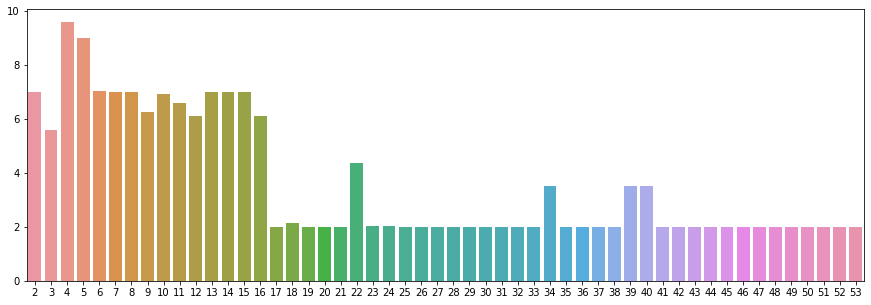

In [237]:
sns.barplot(x=tags_comparison["average_n_job_per_build"].index, \
            y=tags_comparison["average_n_job_per_build"].values)

**Number of builds per pull request**

In [247]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_pr_builds(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    _builds = _all_builds[(_all_builds.event_type == "pull_request")]
    return len(_builds)/len(_all_builds)

def calculate_percentage_pr_builds_pr(row):
    return calculate_percentage_pr_builds(row, tags_iterative_pr_commits)
def calculate_percentage_pr_builds_direct(row):
    return calculate_percentage_pr_builds(row, tags_comparison_commits)
def calculate_percentage_pr_builds_fix(row):
    return calculate_percentage_pr_builds(row, tags_fix_commits)
def calculate_percentage_pr_builds_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_pr_builds(row, _tmp)

In [248]:
tags_comparison["percentage_pr_builds"] = tags_comparison.apply(calculate_percentage_pr_builds_pr_and_fix, axis=1)

<AxesSubplot:>

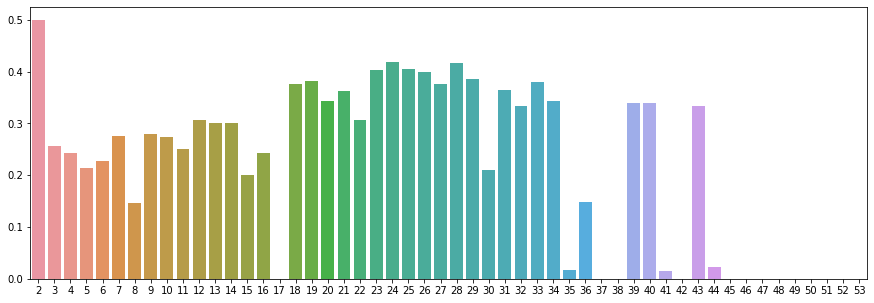

In [249]:
sns.barplot(x=tags_comparison["percentage_pr_builds"].index, \
            y=tags_comparison["percentage_pr_builds"].values)

In [250]:
tags_comparison[tags_comparison.percentage_pr_builds == 0.4]

,from_author_date,to_author_date,ahead_by,behind_by,from_sha,to_sha,ahead_behind_sum,diff_author_dates,diff_author_days,from_commit_date,to_commit_date,diff_commit_dates,diff_commit_days,to_tag,from_tag,mean_job_duration_builds_passed_or_failed,average_failed_job_per_commit,median_n_job_per_pull_request,median_n_job_per_pull_request_2,median_n_job_per_commitmessage,percentage_canceled_or_errored_job,average_n_job_per_build,average_n_build_per_pr,percentage_pr_builds
26,2017-11-07 15:03:37,2017-12-20 16:32:02,25,0,5d031d9d2ac3f69b4b9bc600d50563b1886c7d8b,426519346f51f7b980a76f9050f983110550509d,25,43 days 01:28:25,43.0614,2017-11-07 16:03:37,2017-12-20 17:32:02,43 days 01:28:25,43.0614,6.7.1,6.7,454.87931,1.75,2.0,NaN,6.0,0.104348,2.0,0.4,0.4


In [251]:
tags_comparison[tags_comparison.percentage_pr_builds == 0][["from_tag", "to_tag"]]

,from_tag,to_tag
17,6.1,6.1.1
37,7.3,7.4
38,7.4,7.5
42,7.8,7.9
45,7.9.1,7.9.3
46,7.9.3,7.9.4
47,8.0,8.1
48,8.1,8.2
49,8.2,8.3
50,8.3,8.3.1


* 0% pull request builds may indicate mostly bug fixing done directly on the version branch. 
Indeed all the pairs with 0% do not represent major version upgrades

**Average build duration**

In [267]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_build_duration(row, commitsDf, state=None):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _all_builds = get_builds_from_commits(_commits)
    if(not state):
        return _all_builds.duration.mean()
    return _all_builds[_all_builds.state==state].duration.mean()

def calculate_average_build_duration_pr(row):
    return calculate_average_build_duration(row, tags_iterative_pr_commits)
def calculate_average_build_duration_direct(row):
    return calculate_average_build_duration(row, tags_comparison_commits)
def calculate_average_build_duration_fix(row):
    return calculate_average_build_duration(row, tags_fix_commits)
def calculate_average_build_duration_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_build_duration(row, _tmp)
def calculate_average_passed_build_duration_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_build_duration(row, _tmp, "passed")

In [268]:
tags_comparison["average_build_duration"] = tags_comparison.apply(calculate_average_build_duration_pr_and_fix, axis=1)

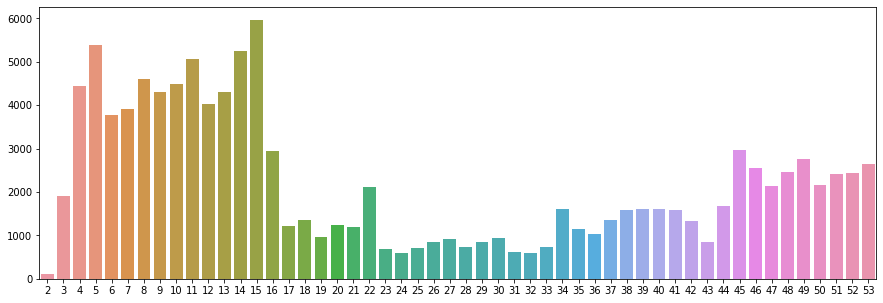

In [275]:
sns.barplot(x=tags_comparison["average_build_duration"].index, \
            y=tags_comparison["average_build_duration"].values)
plt.show()

In [276]:
tags_comparison["average_passed_build_duration"] = tags_comparison.apply(calculate_average_passed_build_duration_pr_and_fix, axis=1)

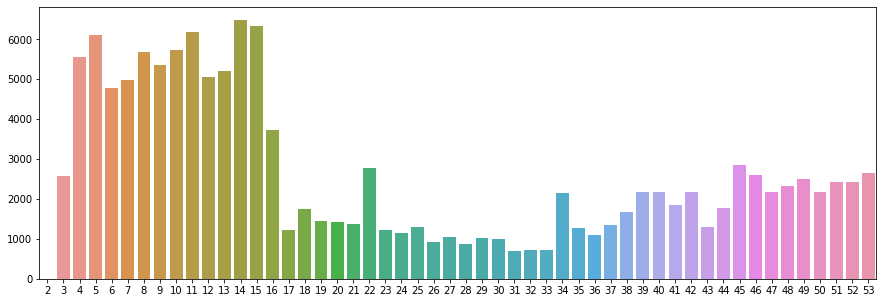

In [277]:
sns.barplot(x=tags_comparison["average_passed_build_duration"].index, \
            y=tags_comparison["average_passed_build_duration"].values)
plt.show()

### Jobs metrics

**Average job duration**

In [159]:
jobs["duration"] = (jobs.finished_at - jobs.started_at) / np.timedelta64(1, "s")

In [170]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_job_duration(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    return _jobs.duration.mean()

def calculate_average_job_duration_pr(row):
    return calculate_average_job_duration(row, tags_iterative_pr_commits)
def calculate_average_job_duration_direct(row):
    return calculate_average_job_duration(row, tags_comparison_commits)
def calculate_average_job_duration_fix(row):
    return calculate_average_job_duration(row, tags_fix_commits)

In [171]:
tags_comparison["mean_job_duration_builds_passed_or_failed"] = tags_comparison.apply(calculate_average_job_duration_pr, axis=1)

**Average failed jobs per commit**

In [176]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_average_failed_job_per_commit(row, commitsDf):
    _build_ids = builds[builds.state.isin(["passed", "failed"])].id
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.buildid.isin(_build_ids)]
    _jobs = _jobs[_jobs.state == "failed"]
    return _jobs.groupby("commitsha").state.count().mean()

def calculate_average_failed_job_per_commit_pr(row):
    return calculate_average_failed_job_per_commit(row, tags_iterative_pr_commits)
def calculate_average_failed_job_per_commit_direct(row):
    return calculate_average_failed_job_per_commit(row, tags_comparison_commits)
def calculate_average_failed_job_per_commit_fix(row):
    return calculate_average_failed_job_per_commit(row, tags_fix_commits)
def calculate_average_failed_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_average_failed_job_per_commit(row, _tmp)

In [179]:
tags_comparison["average_failed_job_per_commit"] = tags_comparison.apply(calculate_average_failed_job_per_commit_pr, axis=1)

<AxesSubplot:>

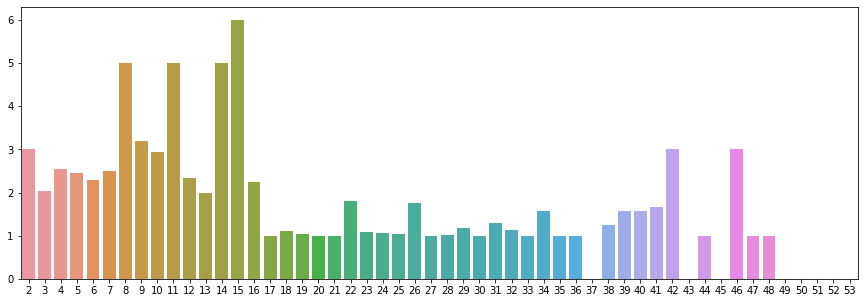

In [206]:
sns.barplot(x=tags_comparison["average_failed_job_per_commit"].index, \
            y=tags_comparison["average_failed_job_per_commit"].values)

**Number of jobs per pull request**

In [196]:
### Mean or median of number of jobs per pull request
def calculate_median_n_job_per_pull_request(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits) & jobs.commitref.str.contains("refs/pull/")]
    return _jobs.groupby("commitref").id.count().median()
    
def calculate_median_n_job_per_pull_request_per_commit_pr(row):
    return calculate_median_n_job_per_pull_request(row, tags_iterative_pr_commits)
def calculate_median_n_job_per_pull_request_per_commit_direct(row):
    return calculate_median_n_job_per_pull_request(row, tags_comparison_commits)
def calculate_median_n_job_per_pull_request_per_commit_fix(row):
    return calculate_median_n_job_per_pull_request(row, tags_fix_commits)
def calculate_median_n_job_per_pull_request_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_median_n_job_per_pull_request(row, _tmp)

In [200]:
tags_comparison["median_n_job_per_pull_request"] =\
tags_comparison.apply(calculate_median_n_job_per_pull_request_commit_pr_and_fix, axis=1)

<AxesSubplot:>

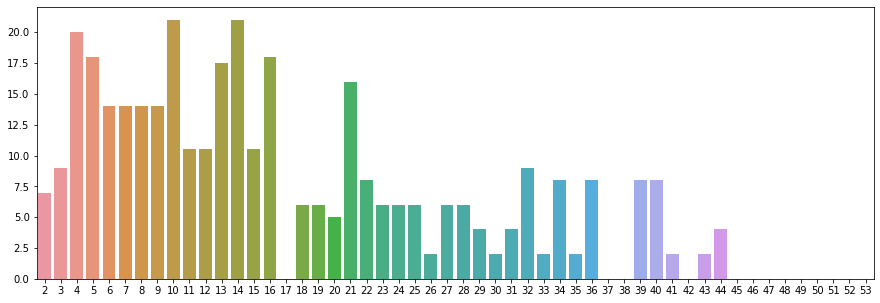

In [205]:
sns.barplot(x=tags_comparison["median_n_job_per_pull_request"].index, \
            y=tags_comparison["median_n_job_per_pull_request"].values)

**Median number of jobs per commitmessage (if starting with SONAR-)**

In [219]:
### Mean or median of number of jobs per pull request
def calculate_median_n_job_per_commitmessage(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return _jobs.groupby("commitmessage").id.count().median()
    
def calculate_median_n_job_per_commitmessage_per_commit_pr(row):
    return calculate_median_n_job_per_commitmessage(row, tags_iterative_pr_commits)
def calculate_median_n_job_per_commitmessage_per_commit_direct(row):
    return calculate_median_n_job_per_commitmessage(row, tags_comparison_commits)
def calculate_median_n_job_per_commitmessage_per_commit_fix(row):
    return calculate_median_n_job_per_commitmessage(row, tags_fix_commits)
def calculate_median_n_job_per_commitmessage_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_median_n_job_per_commitmessage(row, _tmp)

In [220]:
tags_comparison["median_n_job_per_commitmessage"] =\
tags_comparison.apply(calculate_median_n_job_per_commitmessage_per_commit_pr_and_fix, axis=1)

<AxesSubplot:>

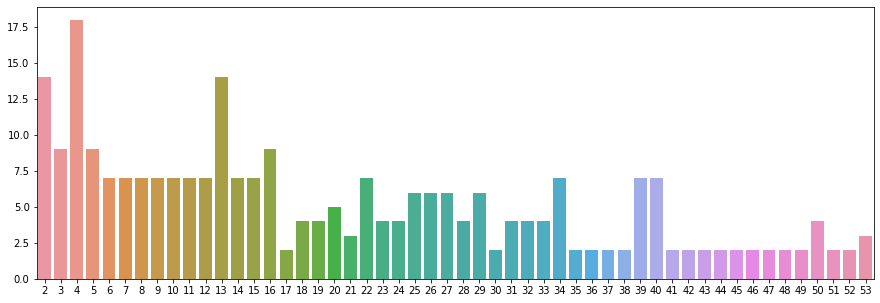

In [221]:
sns.barplot(x=tags_comparison["median_n_job_per_commitmessage"].index, \
            y=tags_comparison["median_n_job_per_commitmessage"].values)

**Number of jobs canceled or errored**

In [222]:
### Mean or median of duration for jobs not from canceled or errored builds
def calculate_percentage_canceled_or_errored_job(row, commitsDf):
    _x = commitsDf
    _commits = _x[(_x.from_tag == row.from_tag) & (_x.to_tag == row.to_tag)].commitsha
    _jobs = jobs[jobs.commitsha.isin(_commits)]
    return len(_jobs[_jobs.state.isin(["canceled", "errored"])]) / len(_jobs)

def calculate_percentage_canceled_or_errored_job_per_commit_pr(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_iterative_pr_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_direct(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_comparison_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_fix(row):
    return calculate_percentage_canceled_or_errored_job(row, tags_fix_commits)
def calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix(row):
    _tmp = tags_iterative_pr_commits.append(tags_fix_commits)
    return calculate_percentage_canceled_or_errored_job(row, _tmp)

In [223]:
tags_comparison["percentage_canceled_or_errored_job"] =\
tags_comparison.apply(calculate_percentage_canceled_or_errored_job_per_commit_pr_and_fix, axis=1)

<AxesSubplot:>

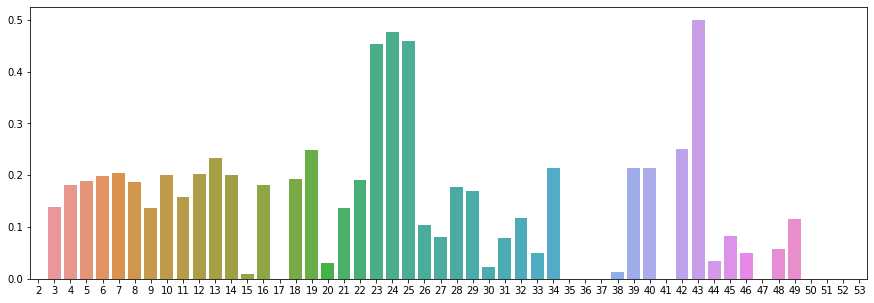

In [224]:
sns.barplot(x=tags_comparison["percentage_canceled_or_errored_job"].index, \
            y=tags_comparison["percentage_canceled_or_errored_job"].values)

In [279]:
tags_comparison.columns

Index(['from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date', 'to_commit_date',
       'diff_commit_dates', 'diff_commit_days', 'to_tag', 'from_tag',
       'mean_job_duration_builds_passed_or_failed',
       'average_failed_job_per_commit', 'median_n_job_per_pull_request',
       'median_n_job_per_pull_request_2', 'median_n_job_per_commitmessage',
       'percentage_canceled_or_errored_job', 'average_n_job_per_build',
       'average_n_build_per_pr', 'percentage_pr_builds', 'build_duration',
       'average_build_duration', 'average_passed_build_duration'],
      dtype='object')